# ResnetTrick_s256bs16_e80

> size 256 bs 16 80 epochs runs.

# setup and imports

In [ ]:
# pip install git+https://github.com/ayasyrev/model_constructor

In [ ]:
# pip install git+https://github.com/kornia/kornia

In [ ]:
from kornia.contrib import MaxBlurPool2d

In [ ]:
from fastai.basic_train import *
from fastai.vision import *
from fastai.script import *
from model_constructor.net import *
from model_constructor.layers import SimpleSelfAttention, ConvLayer

In [ ]:
#Ranger deep learning optimizer - RAdam + Lookahead combined.
  #https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer

  #Ranger has now been used to capture 12 records on the FastAI leaderboard.

  #This version = 9.3.19  

  #Credits:
  #RAdam -->  https://github.com/LiyuanLucasLiu/RAdam
  #Lookahead --> rewritten by lessw2020, but big thanks to Github @LonePatient and @RWightman for ideas from their code.
  #Lookahead paper --> MZhang,G Hinton  https://arxiv.org/abs/1907.08610

  #summary of changes: 
  #full code integration with all updates at param level instead of group, moves slow weights into state dict (from generic weights), 
  #supports group learning rates (thanks @SHolderbach), fixes sporadic load from saved model issues.
  #changes 8/31/19 - fix references to *self*.N_sma_threshold; 
                  #changed eps to 1e-5 as better default than 1e-8.

import math
import torch
from torch.optim.optimizer import Optimizer, required
import itertools as it

# utils

In [ ]:
class Mish(nn.Module):
    def __init__(self):
        super().__init__()
        print("Mish activation loaded...")

    def forward(self, x):  
        #save 1 second per epoch with no x= x*() and then return x...just inline it.
        return x *( torch.tanh(F.softplus(x))) 

In [ ]:

class Ranger(Optimizer):

    def __init__(self, params, lr=1e-3, alpha=0.5, k=6, N_sma_threshhold=5, betas=(.95,0.999), eps=1e-5, weight_decay=0):
        #parameter checks
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        if not lr > 0:
            raise ValueError(f'Invalid Learning Rate: {lr}')
        if not eps > 0:
            raise ValueError(f'Invalid eps: {eps}')

        #parameter comments:
        # beta1 (momentum) of .95 seems to work better than .90...
        #N_sma_threshold of 5 seems better in testing than 4.
        #In both cases, worth testing on your dataset (.90 vs .95, 4 vs 5) to make sure which works best for you.

        #prep defaults and init torch.optim base
        defaults = dict(lr=lr, alpha=alpha, k=k, step_counter=0, betas=betas, N_sma_threshhold=N_sma_threshhold, eps=eps, weight_decay=weight_decay)
        super().__init__(params,defaults)

        #adjustable threshold
        self.N_sma_threshhold = N_sma_threshhold

        #now we can get to work...
        #removed as we now use step from RAdam...no need for duplicate step counting
        #for group in self.param_groups:
        #    group["step_counter"] = 0
            #print("group step counter init")

        #look ahead params
        self.alpha = alpha
        self.k = k 

        #radam buffer for state
        self.radam_buffer = [[None,None,None] for ind in range(10)]

        #self.first_run_check=0

        #lookahead weights
        #9/2/19 - lookahead param tensors have been moved to state storage.  
        #This should resolve issues with load/save where weights were left in GPU memory from first load, slowing down future runs.

        #self.slow_weights = [[p.clone().detach() for p in group['params']]
        #                     for group in self.param_groups]

        #don't use grad for lookahead weights
        #for w in it.chain(*self.slow_weights):
        #    w.requires_grad = False

    def __setstate__(self, state):
        print("set state called")
        super(Ranger, self).__setstate__(state)


    def step(self, closure=None):
        loss = None
        #note - below is commented out b/c I have other work that passes back the loss as a float, and thus not a callable closure.  
        #Uncomment if you need to use the actual closure...

        #if closure is not None:
            #loss = closure()

        #Evaluate averages and grad, update param tensors
        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Ranger optimizer does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]  #get state dict for this param

                if len(state) == 0:   #if first time to run...init dictionary with our desired entries
                    #if self.first_run_check==0:
                        #self.first_run_check=1
                        #print("Initializing slow buffer...should not see this at load from saved model!")
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)

                    #look ahead weight storage now in state dict 
                    state['slow_buffer'] = torch.empty_like(p.data)
                    state['slow_buffer'].copy_(p.data)

                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                #begin computations 
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                #compute variance mov avg
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                #compute mean moving avg
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1


                buffered = self.radam_buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma
                    if N_sma > self.N_sma_threshhold:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                if N_sma > self.N_sma_threshhold:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)

                p.data.copy_(p_data_fp32)

                #integrated look ahead...
                #we do it at the param level instead of group level
                if state['step'] % group['k'] == 0:
                    slow_p = state['slow_buffer'] #get access to slow param tensor
                    slow_p.add_(self.alpha, p.data - slow_p)  #(fast weights - slow weights) * alpha
                    p.data.copy_(slow_p)  #copy interpolated weights to RAdam param tensor

        return loss

In [ ]:
def get_data(size=128, woof=1, bs=64, workers=None, **kwargs):
    if woof:
        path = URLs.IMAGEWOOF    # if woof 
    else:
        path = URLs.IMAGENETTE
    path = untar_data(path)
    print('data path  ', path)
    n_gpus = num_distrib() or 1
    if workers is None: workers = min(8, num_cpus()//n_gpus)
    return (ImageList.from_folder(path).split_by_folder(valid='val')
            .label_from_folder().transform(([flip_lr(p=0.5)], []), size=size)
            .databunch(bs=bs, num_workers=workers)
            .presize(size, scale=(0.35,1))
            .normalize(imagenet_stats))

In [ ]:
def get_learn(
        gpu:Param("GPU to run on", str)=None,
        woof: Param("Use imagewoof (otherwise imagenette)", int)=1,
        size: Param("Size (px: 128,192,224)", int)=128,
        alpha: Param("Alpha", float)=0.99, 
        mom: Param("Momentum", float)=0.95, #? 0.9
        eps: Param("epsilon", float)=1e-6,
        bs: Param("Batch size", int)=64,
        mixup: Param("Mixup", float)=0.,
        opt: Param("Optimizer (adam,rms,sgd)", str)='ranger',
        sa: Param("Self-attention", int)=0,
        sym: Param("Symmetry for self-attention", int)=0,
        model: Param('model as partial', callable) = xresnet50
        ):
 
    if   opt=='adam' : opt_func = partial(optim.Adam, betas=(mom,alpha), eps=eps)
    elif opt=='ranger'  : opt_func = partial(Ranger,  betas=(mom,alpha), eps=eps)
    data = get_data(size, woof, bs)
    learn = (Learner(data, model(), wd=1e-2, opt_func=opt_func,
             metrics=[accuracy,top_k_accuracy],
             bn_wd=False, true_wd=True,
             loss_func = LabelSmoothingCrossEntropy(),))
    print('Learn path', learn.path)
    if mixup: learn = learn.mixup(alpha=mixup)
    return learn

In [ ]:
def plot(learn):
    learn.recorder.plot_losses()
    learn.recorder.plot_metrics()
    learn.recorder.plot_lr(show_moms=True)
Learner.plot = plot

# ResBlock

In [ ]:
class NewResBlock(Module):
    def __init__(self, expansion, ni, nh, stride=1, 
                 conv_layer=ConvLayer, act_fn=act_fn,
#                  pool=nn.AvgPool2d(2, ceil_mode=True), sa=False,sym=False):
                 pool=nn.AvgPool2d(2, ceil_mode=True), sa=False,sym=False, zero_bn=True):
        nf,ni = nh*expansion,ni*expansion
        self.reduce = noop if stride==1 else pool
        layers  = [(f"conv_0", conv_layer(ni, nh, 3, stride=stride, act_fn=act_fn)),
                   (f"conv_1", conv_layer(nh, nf, 3, zero_bn=zero_bn, act=False))
        ] if expansion == 1 else [
                   (f"conv_0",conv_layer(ni, nh, 1, act_fn=act_fn)),
                   (f"conv_1",conv_layer(nh, nh, 3, stride=1, act_fn=act_fn)), #!!!
                   (f"conv_2",conv_layer(nh, nf, 1, zero_bn=zero_bn, act=False))
        ]
        if sa: layers.append(('sa', SimpleSelfAttention(nf,ks=1,sym=sym)))
        self.convs = nn.Sequential(OrderedDict(layers))
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act=False)
        self.merge =act_fn

    def forward(self, x): 
        o = self.reduce(x)
        return self.merge(self.convs(o) + self.idconv(o))

# Model Constructor

In [ ]:
model = xresnet50(c_out=10)

In [ ]:
model.block = NewResBlock

In [ ]:
pool = MaxBlurPool2d(3, True)

In [ ]:
model.pool = pool
model.stem_pool = pool

In [ ]:
# model.stem_sizes = [3,32,32,64]
model.stem_sizes = [3,32,64,64]

model.act_fn= Mish()
model.sa = True

Mish activation loaded...


## repr model

In [ ]:
model()

Sequential(
  model xresnet50
  (stem): Sequential(
    (conv_0): ConvLayer(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act_fn): Mish()
    )
    (conv_1): ConvLayer(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act_fn): Mish()
    )
    (conv_2): ConvLayer(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act_fn): Mish()
    )
    (stem_pool): MaxBlurPool2d()
  )
  (body): Sequential(
    (l_0): Sequential(
      (bl_0): NewResBlock(
        (convs): Sequential(
          (conv_0): ConvLayer(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 

In [ ]:
model.stem

Sequential(
  (conv_0): ConvLayer(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_fn): Mish()
  )
  (conv_1): ConvLayer(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_fn): Mish()
  )
  (conv_2): ConvLayer(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_fn): Mish()
  )
  (stem_pool): MaxBlurPool2d()
)

In [ ]:
model.body

Sequential(
  (l_0): Sequential(
    (bl_0): NewResBlock(
      (convs): Sequential(
        (conv_0): ConvLayer(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act_fn): Mish()
        )
        (conv_1): ConvLayer(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act_fn): Mish()
        )
        (conv_2): ConvLayer(
          (conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (idconv): ConvLayer(
        (conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [ ]:
model.head

Sequential(
  (pool): AdaptiveAvgPool2d(output_size=1)
  (flat): Flatten()
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)

# Parameters

In [ ]:
lr = 0.004
epochs = 80
moms = (0.95,0.95)
start_pct = 0.4
size=256
bs=16

# Lr find

In [ ]:
learn = get_learn(model=model,size=size,bs=bs)

data path   /notebooks/data/imagewoof2
Learn path /notebooks/data/imagewoof2


In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


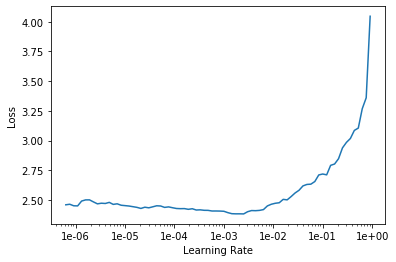

In [ ]:
learn.recorder.plot()

# epochs 80 9045

In [ ]:
learn = get_learn(model=model,size=size,bs=bs, mixup=0.2)
learn.fit_fc(epochs, lr, moms,start_pct)

data path   /notebooks/data/imagewoof2
Learn path /notebooks/data/imagewoof2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.069963,1.887730,0.370323,0.865106,02:58
1,1.898108,1.707023,0.461441,0.906592,03:02
2,1.716372,1.530373,0.555867,0.929244,03:02
3,1.641991,1.408172,0.610842,0.941970,03:04
4,1.527325,1.322380,0.646220,0.955205,03:03
5,1.508081,1.196630,0.721558,0.963604,03:04
6,1.459687,1.125820,0.761008,0.972512,03:05
7,1.379063,1.104505,0.762026,0.972258,03:04
8,1.386399,1.099225,0.755154,0.973785,03:04
9,1.382449,1.060668,0.782642,0.973021,03:04


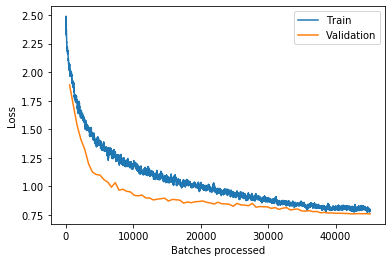

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn = get_learn(model=model,size=size,bs=bs, mixup=0.2)
learn.fit_fc(epochs, lr, moms,start_pct)

data path   /notebooks/data/imagewoof2
Learn path /notebooks/data/imagewoof2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.027628,1.859925,0.373886,0.865106,03:05
1,1.862299,1.682527,0.493001,0.899211,03:07
2,1.733764,1.446899,0.584118,0.941970,03:06
3,1.629644,1.424300,0.596589,0.941715,03:06
4,1.568586,1.263322,0.678799,0.957241,03:06
5,1.476403,1.223294,0.701196,0.965131,03:06
6,1.469095,1.145937,0.743446,0.969967,03:06
7,1.392344,1.078633,0.768389,0.972003,03:07
8,1.380457,1.069275,0.783915,0.972258,03:06
9,1.348678,1.072524,0.774752,0.974039,03:06


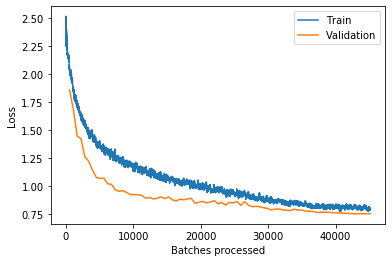

In [ ]:
learn.recorder.plot_losses()

## e80 results

In [ ]:
acc = np.array([0.903283, 0.909392])

In [ ]:
acc.mean(), acc.std()

(0.9063375, 0.0030545000000000155)